In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [3]:
csv_data = pd.read_csv("/kaggle/input/fss1000-a-1000-class-fewshot-segmentation/fss-1000.csv", index_col="Unnamed: 0")

In [4]:
csv_data.head()

,in_file,out_file,class,x_min,y_min,x_max,y_max,x_center,y_center,width,height,class_id
0,./carrot/9.jpg,./carrot/9.png,carrot,0.044643,0.223214,0.580357,0.830357,0.312500,0.526786,0.535714,0.607143,0
1,./carrot/2.jpg,./carrot/2.png,carrot,0.066964,0.321429,0.964286,0.669643,0.515625,0.495536,0.897321,0.348214,0
2,./carrot/8.jpg,./carrot/8.png,carrot,0.174107,0.098214,0.736607,0.696429,0.455357,0.397321,0.562500,0.598214,0
3,./carrot/4.jpg,./carrot/4.png,carrot,0.098214,0.303571,0.875000,0.933036,0.486607,0.618304,0.776786,0.629464,0
4,./carrot/7.jpg,./carrot/7.png,carrot,0.156250,0.558036,0.848214,0.875000,0.502232,0.716518,0.691964,0.316964,0


In [5]:
csv_data["class"].value_counts()

class
brush_pen        10
carrot           10
pidan            10
beaver           10
kunai            10
                 ..
carp             10
siamang          10
rubber_eraser    10
motarboard       10
wafer            10
Name: count, Length: 1000, dtype: int64

In [6]:
base_dir = '/kaggle/input/fss1000-a-1000-class-fewshot-segmentation/FSS-1000/'

# Update 'in_file' and 'out_file' columns to include the full path
csv_data['in_file'] = csv_data['in_file'].map(lambda x: os.path.join(base_dir, x))
csv_data['out_file'] = csv_data['out_file'].map(lambda x: os.path.join(base_dir, x))

In [7]:
class_to_id = dict(zip(csv_data["class"], csv_data["class_id"]))
id_to_class = dict(zip(csv_data["class_id"], csv_data["class"]))

In [8]:
from collections import defaultdict
class_to_files_map = defaultdict(list)
for _, row in csv_data.iterrows():
    class_to_files_map[row['class']].append(row['in_file'])

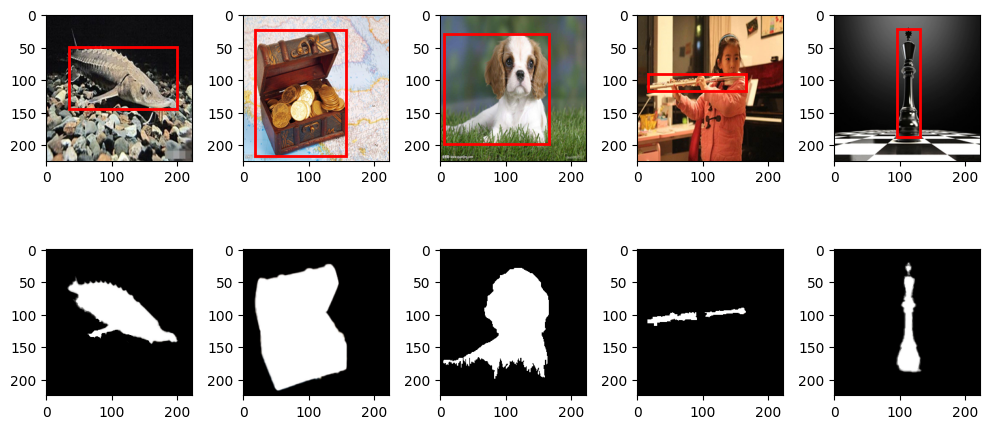

In [9]:
sample_indices = np.random.choice(len(csv_data), 5)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, index in enumerate(sample_indices):
    ax1, ax2 = axes[0][i], axes[1][i]
    input_image = Image.open(csv_data.iloc[index]['in_file'])
    segmentation_mask = Image.open(csv_data.iloc[index]['out_file'])
    ax1.imshow(input_image)
    ax2.imshow(segmentation_mask)

    x_min, y_min, width, height = csv_data.iloc[index]['x_min']*224,csv_data.iloc[index]['y_min']*224, csv_data.iloc[index]['width']*224, csv_data.iloc[index]['height']*224
    rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)

plt.tight_layout()
plt.show();

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# define classes and functions

In [11]:
from sklearn.model_selection import train_test_split

def split_data(csv_data, unique_class_ids, random_state=42):
    """
    Splits the data into training, validation, test, and evaluation sets based on class IDs.

    Args:
    - csv_data (DataFrame): DataFrame containing the data.
    - id_to_class (dict): Mapping of class IDs to class labels.
    - train_size (float): Size of the training set (default: 0.8).
    - test_size (float): Size of the test set. If None, test set will be complementary to train set (default: None).
    - random_state (int): Random seed for reproducibility (default: None).

    Returns:
    - train_data (DataFrame): Training data.
    - val_data (DataFrame): Validation data.
    - test_data (DataFrame): Test data.
    - eval_data (DataFrame): Evaluation data.
    """

    # Select class IDs for training
    train_class_ids = np.random.choice(unique_class_ids, size=800, replace=False)

    # Use remaining class IDs for testing
    test_class_ids = np.setdiff1d(unique_class_ids, train_class_ids)

    # Filter data for training
    train_data = csv_data[csv_data['class_id'].isin(train_class_ids)]

    # Split training data into train and validation sets
    train_data, val_data = train_test_split(train_data, train_size=0.8, stratify=train_data['class_id'], random_state=random_state)

    # Filter data for testing
    test_data = csv_data[csv_data['class_id'].isin(test_class_ids)]
    
    train_data.reset_index(drop=True, inplace=True)
    val_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)

    return train_data, val_data, test_data

In [12]:
class SiameseDataset(Dataset):
    """
    A PyTorch dataset for loading triplet face images.

    Args:
        data (DataFrame): A Pandas DataFrame containing image paths and class IDs.
    """

    def __init__(self, data):
        """
        Initialize the TripletFaceDataset.

        Args:
            data (DataFrame): A Pandas DataFrame containing image paths and class IDs.
        """
        self.data = data

    def read_info(self, index):
        """
        Read image information for a given index.

        Args:
            index (int): Index of the image to read.

        Returns:
            tuple: A tuple containing path, cropbox, and class ID of the image.
        """
        if index < 0 or index >= len(self.data):
            raise IndexError("Index out of range")

        path = self.data.iloc[index]["in_file"]
        x_min, y_min, width, height = self.data.iloc[index][["x_min", "y_min", "width", "height"]] * 224
        cropbox = (x_min, y_min, x_min + width, y_min + height)
        class_id = self.data.iloc[index]["class_id"]

        return path, cropbox, class_id

    def read_image(self, path):
        """
        Read an image from the given path.

        Args:
            path (str): Path to the image file.

        Returns:
            PIL.Image.Image: The loaded image.
        """
        image = Image.open(path)
        return image

    def transform_image(self, image, cropbox):
        """
        Apply transformations to the image.

        Args:
            image (PIL.Image.Image): The input image.
            cropbox (tuple): Coordinates for cropping the image.

        Returns:
            torch.Tensor: The transformed image.
        """
        image = image.crop(cropbox)
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224), antialias=True)(image)
        return image

    def __getitem__(self, index):
        """
        Get the triplet (anchor, positive\negative, its label) for a given index.

        Args:
            index (int): Index of the anchor image.

        """
        # Select anchor image
        anchor_path, anchor_cropbox, anchor_class_id = self.read_info(index)
        anchor_image = self.read_image(anchor_path)
        anchor_image = self.transform_image(anchor_image, anchor_cropbox)

        # Generate random label (0 or 1)
        label = np.random.randint(2)

        if label == 0:
            # Select negative image
            negative_index = index
            negative_indices = self.data[self.data['class_id'] != anchor_class_id].index
            if len(negative_indices) == 0:
                raise ValueError("No negative indices available for class_id {}".format(anchor_class_id))
            while negative_index == index:
                negative_index = np.random.choice(negative_indices)
            negative_path, negative_cropbox, negative_class_id = self.read_info(negative_index)
            negative_image = self.read_image(negative_path)
            negative_image = self.transform_image(negative_image, negative_cropbox)

            return anchor_image, negative_image, label

        else:
            # Select positive image
            positive_index = index
            positive_indices = self.data[self.data['class_id'] == anchor_class_id].index
            if len(positive_indices) == 0:
                raise ValueError("No positive indices available for class_id {}".format(anchor_class_id))
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
            positive_path, positive_cropbox, positive_class_id = self.read_info(positive_index)
            positive_image = self.read_image(positive_path)
            positive_image = self.transform_image(positive_image, positive_cropbox)

            return anchor_image, positive_image, label


    def __len__(self):
        """
        Get the total number of images in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.data)


In [13]:
class SiameseTestDataset(SiameseDataset):
    """
    A PyTorch dataset for loading triplet face images for testing.

    Args:
        data (DataFrame): A Pandas DataFrame containing image paths and class IDs.
    """

    def __getitem__(self, index):
        """
        Get a query image and a random image from each class for a given index.

        Args:
            index (int): Index of the query image.

        Returns:
            tuple: A tuple containing the query image and a random image from each class.
        """
        # Get the query image
        query_path, query_cropbox, query_class_id = self.read_info(index)
        query_image = self.read_image(query_path)
        query_image = self.transform_image(query_image, query_cropbox)

        # Get a random image from each class
        random_images_per_class = []
        for class_id in self.data["class_id"].unique():
            class_images_data = self.data[self.data['class_id'] == class_id]
            random_index = np.random.choice(class_images_data.index)
            random_path, random_cropbox, _ = self.read_info(random_index)
            random_image = self.read_image(random_path)
            random_image = self.transform_image(random_image, random_cropbox)
            random_images_per_class.append(random_image)

        return query_class_id, query_image, random_images_per_class


In [14]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network for face recognition using pretrained ResNet50 as backbone.

    Args:
        None
    """
    
    def __init__(self):
        """
        Initializes the SiameseNetwork.

        Args:
            None
        """
        nn.Module.__init__(self)
        # Load pretrained resnet50 model
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.1),  # Adding dropout after the ReLU activation
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.1),  # Adding dropout after the ReLU activation
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),  # Adding dropout after the ReLU activation

        )

    def forward(self, x):
        """
        Forward pass through the network for a single input.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the fully connected layers.
        """
        # Forward pass through EfficientNet backbone
        x = self.resnet(x)
        # Forward pass through the fully connected layers
        x = self.fc(x)
        return x

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss Function
    Computes the contrastive loss for siamese networks.

    Contrastive loss encourages the model to learn embeddings (output vectors) such that
    similar samples are close together and dissimilar samples are far apart.

    Args:
        margin (float, optional): Margin value for contrastive loss. Defaults to 1.0.
    """
    
    def __init__(self, margin=1.0):
        """
        Initialize the ContrastiveLoss module.

        Args:
            margin (float, optional): Margin value for contrastive loss. Defaults to 1.0.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Compute contrastive loss between pairs of embeddings.

        Args:
            output1 (torch.Tensor): Embeddings for the first set of samples.
            output2 (torch.Tensor): Embeddings for the second set of samples.
            label (torch.Tensor): Labels indicating whether the pairs are similar (0) or dissimilar (1).

        Returns:
            torch.Tensor: Contrastive loss value.
        """
        # Calculate Euclidean distance between the embeddings
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        # Loss for similar pairs
        loss_similar = (1 - label) * torch.pow(euclidean_distance, 2)
        
        # Loss for dissimilar pairs
        loss_dissimilar = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        
        # Compute mean of the loss
        loss_contrastive = torch.mean(loss_similar + loss_dissimilar)
        
        
        return loss_contrastive

In [16]:
def visualize_triplet_dataset(dataset, num_iterations=5):
    """
    Visualize a TripletFaceDataset.

    Args:
        dataset (TripletFaceDataset): The TripletFaceDataset instance.
        num_iterations (int): Number of iterations to visualize.

    Returns:
        None
    """
    # Creating an iterator
    triplet_iterator = iter(dataset)

    # Create a figure with subplots
    fig, axes = plt.subplots(5, 2, figsize=(15, 15))

    # Iterate over the dataset
    for i in range(5):
        try:
            # Fetching the triplet images using next()
            image1, image2, label = next(triplet_iterator)
            print(f'Label is {label}')
            
            axes[i][0].imshow(image1.permute(1, 2, 0))
            plt.axis('off')

            axes[i][1].imshow(image2.permute(1, 2, 0))
            plt.axis('off')

        except StopIteration:
            print("End of dataset reached")
            break

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [17]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def train_epoch(model, criterion, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0
    for batch_idx, (image1, image2, label) in enumerate(dataloader):
        image1, image2, label = image1.to(device), image2.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        output1 = model(image1)
        output2 = model(image2)
        
        loss = criterion(output1, output2, label)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        del image1, image2, label, output1, output2, loss
        torch.cuda.empty_cache()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        total_loss = 0.0
        for image1, image2, label in dataloader:
            image1, image2, label = image1.to(device), image2.to(device), label.to(device)
            output1 = model(image1)
            output2 = model(image2)
            loss = criterion(output1, output2, label)
            total_loss += loss.item()

            # Free up GPU memory
            del image1, image2, label, output1, output2, loss
            torch.cuda.empty_cache()

    return total_loss / len(dataloader)

In [18]:
from tqdm import tqdm
def train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, device, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_epoch(model, criterion, optimizer, train_dataloader, device)
        val_loss = evaluate(model, val_dataloader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Free up GPU memory
        del train_loss, val_loss
        torch.cuda.empty_cache()

In [19]:
from sklearn.metrics import accuracy_score

def test(model, dataloader, device):
    """
    Predict class IDs of images and calculate accuracy.

    Args:
        model (torch.nn.Module): The Siamese network model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the Siamese test dataset.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for query_class_id, query_image, random_images_per_class in dataloader:
            query_image = query_image.to(device)
            random_images_per_class = [img.to(device) for img in random_images_per_class]

            # Calculate similarities between query image and each class image
            similarities = []
            for class_image in random_images_per_class:
                output1 = model(query_image)
                output2 = model(class_image)
                similarity = F.pairwise_distance(output1, output2)
                similarities.append(similarity.tolist())  # Use .tolist() instead of .item()

            # Predict class ID based on the highest similarity
            predicted_class_id = torch.tensor(similarities).argmin().item()
            all_predictions.append(predicted_class_id)

            # Append true class ID
            all_labels.append(query_class_id)

            # Free up GPU memory
            del query_image, random_images_per_class, output1, output2, loss
            torch.cuda.empty_cache()

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# spliting to train validation and test

In [20]:
unique_class_ids = list(id_to_class.keys())
train_data, val_data, test_data = split_data(csv_data, unique_class_ids)

# create datasets

In [21]:
train_dataset = SiameseDataset(train_data)
val_dataset = SiameseDataset(val_data)

# visualize (image1, image2, label) examples of train dataset

Label is 1
Label is 1
Label is 1
Label is 1
Label is 0


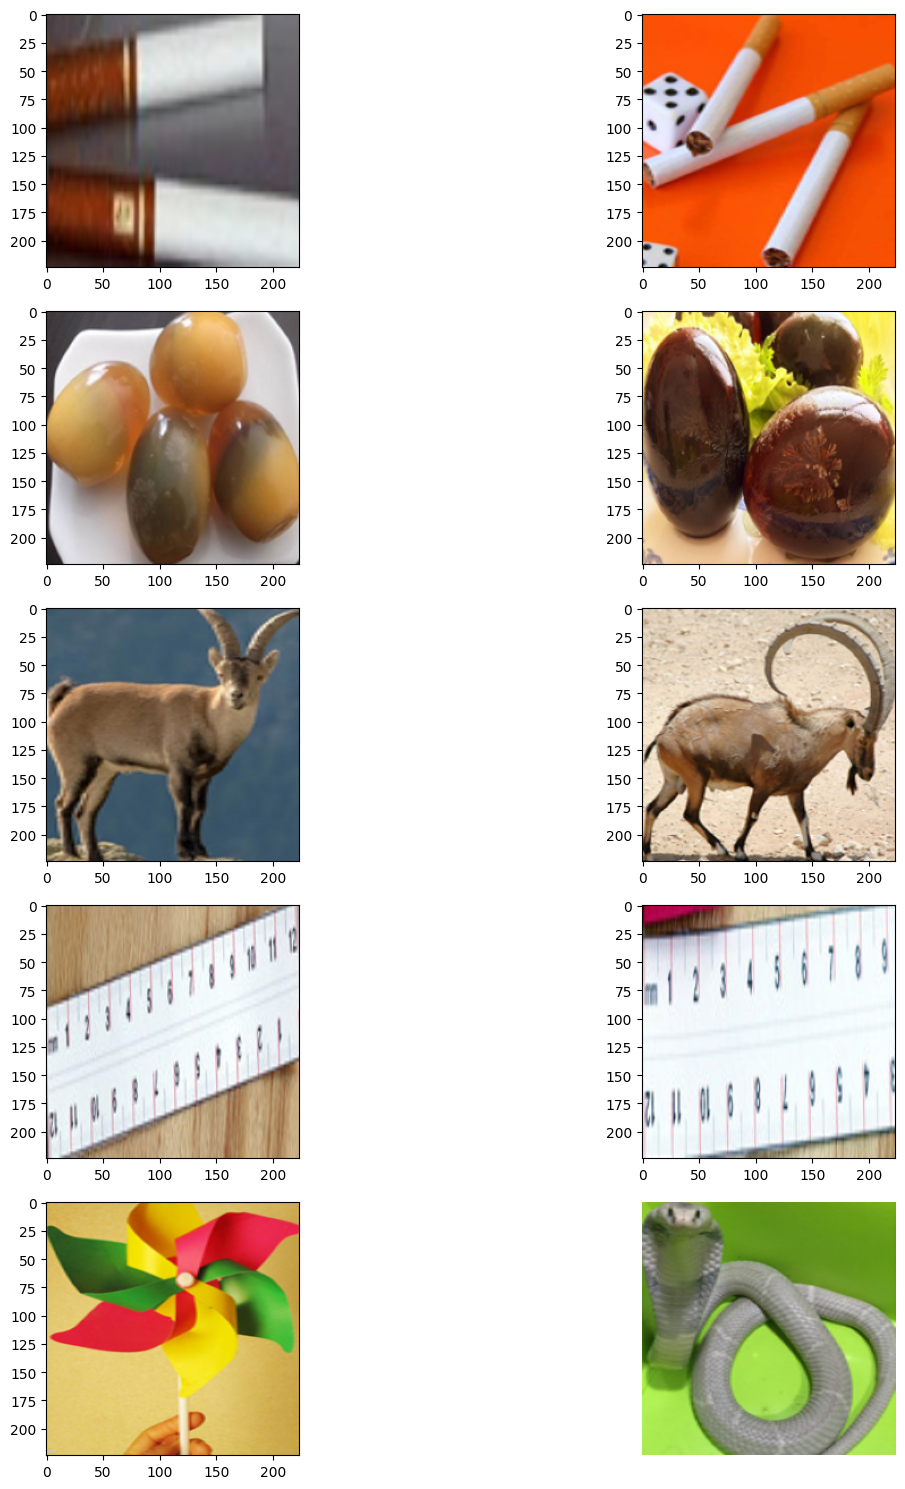

In [22]:
visualize_triplet_dataset(train_dataset)

# dataloaders

In [23]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# training

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, device, num_epochs=5)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 
 20%|██        | 1/5 [02:50<11:21, 170.33s/it]

Epoch 1/5: Train Loss: 0.3070, Val Loss: 0.3390


 40%|████      | 2/5 [04:24<06:16, 125.44s/it]

Epoch 2/5: Train Loss: 0.2969, Val Loss: 0.3403


 60%|██████    | 3/5 [05:57<03:41, 110.91s/it]

Epoch 3/5: Train Loss: 0.2917, Val Loss: 0.3323


 80%|████████  | 4/5 [07:31<01:44, 104.15s/it]

Epoch 4/5: Train Loss: 0.2865, Val Loss: 0.3399


100%|██████████| 5/5 [09:05<00:00, 109.10s/it]

Epoch 5/5: Train Loss: 0.2847, Val Loss: 0.3402


In [25]:
torch.save(model, 'model1.pth')